In [3]:
import tensorflow as tf

In [4]:
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

In [6]:
def crop_brain(image, plot = 'False'):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

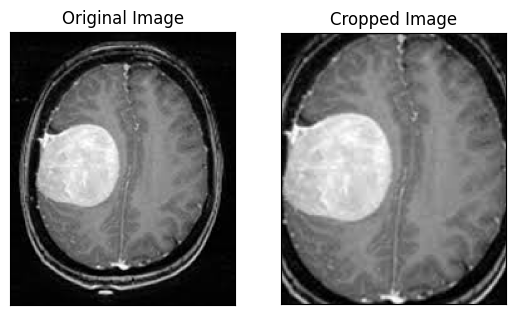

In [7]:
ex_img = cv2.imread(r'./data/brain_tumor_dataset/yes/Y1.jpg')
ex_new_img = crop_brain(ex_img, True)

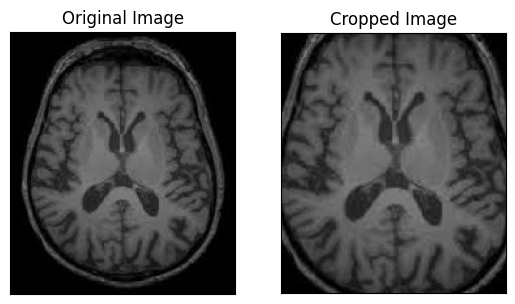

In [8]:
ex_img = cv2.imread(r'./data/brain_tumor_dataset/no/10 no.jpg')
ex_new_img = crop_brain(ex_img, True)

In [9]:
def load_data(dir_list, image_size):
    X = []
    y = []
    image_width, image_height = image_size
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory + '\\' + filename)
            image = crop_brain(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            image = image / 255.
            X.append(image)
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
    X = np.array(X)
    y = np.array(y)
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [10]:
augmented_path = 'augmentedData/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


In [11]:
def plot_sample_images(X, y, n=10):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

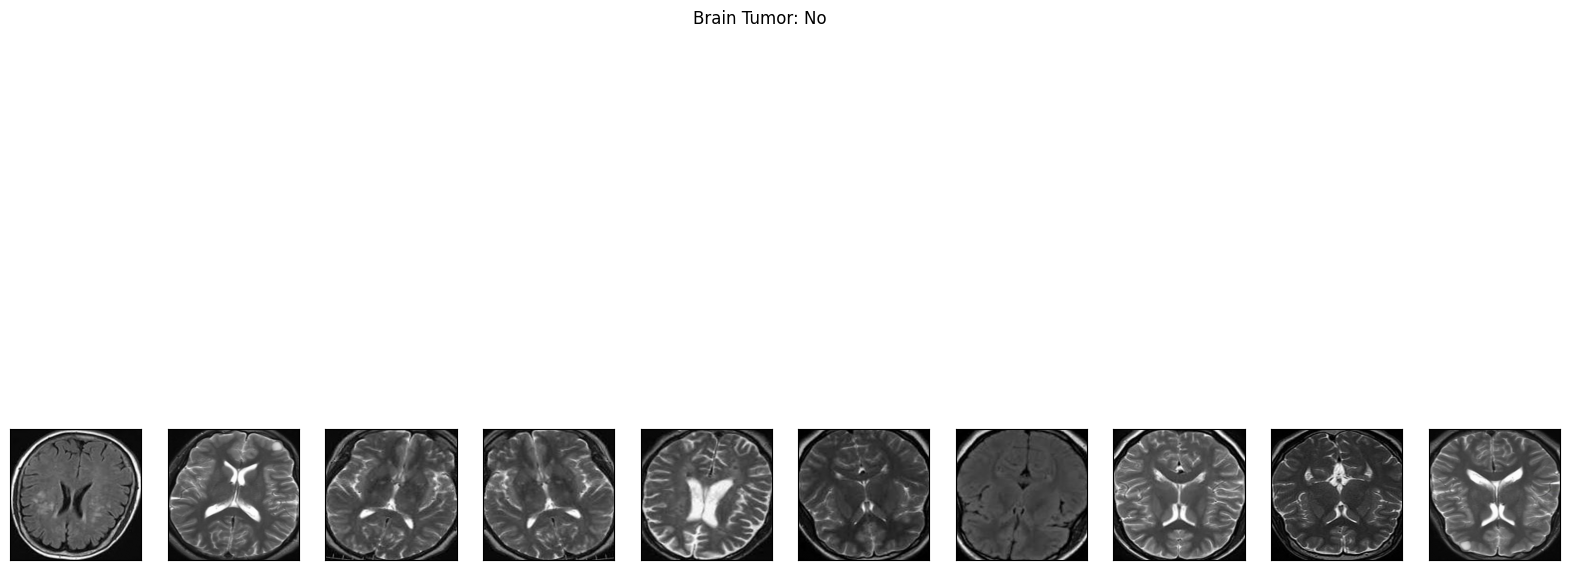

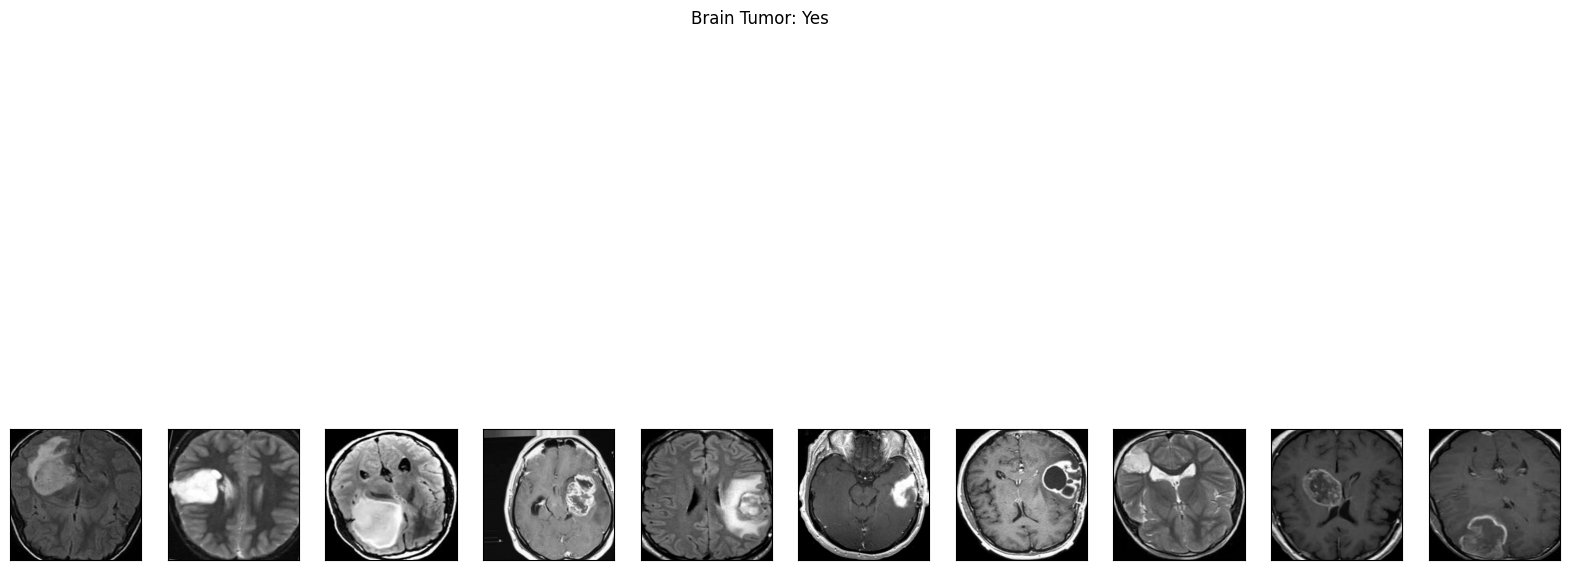

In [12]:
plot_sample_images(X, y)

In [13]:
def split_data(X, y, test_size=0.2):
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [14]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [15]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1445
number of development examples = 310
number of test examples = 310
X_train shape: (1445, 240, 240, 3)
Y_train shape: (1445, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


In [18]:
def build_model(input_shape):
     # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

In [19]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model = build_model(IMG_SHAPE)

In [20]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d (ZeroPaddin  (None, 244, 244, 3)       0         
 g2D)                                                            
                                                                 
 conv0 (Conv2D)              (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation (Activation)     (None, 238, 238, 32)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 59, 59, 32)        0         
                                               

In [21]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

In [23]:
model.fit(x=X_train, y=y_train, batch_size=32, epochs=12, validation_data=(X_val, y_val), callbacks=[checkpoint])

Epoch 1/12
46/46 [==============================] - ETA: 0s - loss: 0.9450 - accuracy: 0.5751INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.62.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.62.model\assets


46/46 [==============================] - 241s 4s/step - loss: 0.9450 - accuracy: 0.5751 - val_loss: 0.6546 - val_accuracy: 0.6226
Epoch 2/12
46/46 [==============================] - ETA: 0s - loss: 0.4947 - accuracy: 0.7522INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.77.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.77.model\assets


46/46 [==============================] - 115s 3s/step - loss: 0.4947 - accuracy: 0.7522 - val_loss: 0.5970 - val_accuracy: 0.7677
Epoch 3/12
46/46 [==============================] - ETA: 0s - loss: 0.4332 - accuracy: 0.8069INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.58.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.58.model\assets


46/46 [==============================] - 103s 2s/step - loss: 0.4332 - accuracy: 0.8069 - val_loss: 0.6481 - val_accuracy: 0.5774
Epoch 4/12
46/46 [==============================] - ETA: 0s - loss: 0.4780 - accuracy: 0.7730INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.70.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.70.model\assets


46/46 [==============================] - 102s 2s/step - loss: 0.4780 - accuracy: 0.7730 - val_loss: 0.5644 - val_accuracy: 0.6968
Epoch 5/12
46/46 [==============================] - ETA: 0s - loss: 0.4631 - accuracy: 0.7882INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.77.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.77.model\assets


46/46 [==============================] - 96s 2s/step - loss: 0.4631 - accuracy: 0.7882 - val_loss: 0.4797 - val_accuracy: 0.7742
Epoch 6/12
46/46 [==============================] - ETA: 0s - loss: 0.3350 - accuracy: 0.8616INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-06-0.80.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-06-0.80.model\assets


46/46 [==============================] - 105s 2s/step - loss: 0.3350 - accuracy: 0.8616 - val_loss: 0.4567 - val_accuracy: 0.8000
Epoch 7/12
46/46 [==============================] - ETA: 0s - loss: 0.3276 - accuracy: 0.8498INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-07-0.81.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-07-0.81.model\assets


46/46 [==============================] - 118s 3s/step - loss: 0.3276 - accuracy: 0.8498 - val_loss: 0.4292 - val_accuracy: 0.8065
Epoch 8/12
46/46 [==============================] - ETA: 0s - loss: 0.2731 - accuracy: 0.8851INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-08-0.65.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-08-0.65.model\assets


46/46 [==============================] - 128s 3s/step - loss: 0.2731 - accuracy: 0.8851 - val_loss: 0.6827 - val_accuracy: 0.6452
Epoch 9/12
46/46 [==============================] - ETA: 0s - loss: 0.2829 - accuracy: 0.8803INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-09-0.77.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-09-0.77.model\assets


46/46 [==============================] - 133s 3s/step - loss: 0.2829 - accuracy: 0.8803 - val_loss: 0.4651 - val_accuracy: 0.7710
Epoch 10/12
46/46 [==============================] - ETA: 0s - loss: 0.2484 - accuracy: 0.9024INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-10-0.84.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-10-0.84.model\assets


46/46 [==============================] - 135s 3s/step - loss: 0.2484 - accuracy: 0.9024 - val_loss: 0.3670 - val_accuracy: 0.8387
Epoch 11/12
46/46 [==============================] - ETA: 0s - loss: 0.2371 - accuracy: 0.8934INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-11-0.81.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-11-0.81.model\assets


46/46 [==============================] - 114s 2s/step - loss: 0.2371 - accuracy: 0.8934 - val_loss: 0.4198 - val_accuracy: 0.8129
Epoch 12/12
46/46 [==============================] - ETA: 0s - loss: 0.3289 - accuracy: 0.8540INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-12-0.68.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-12-0.68.model\assets


46/46 [==============================] - 106s 2s/step - loss: 0.3289 - accuracy: 0.8540 - val_loss: 0.7490 - val_accuracy: 0.6806


In [24]:
history = model.history.history
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


In [25]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

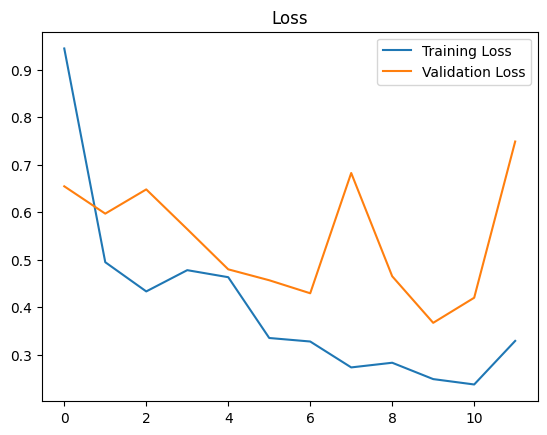

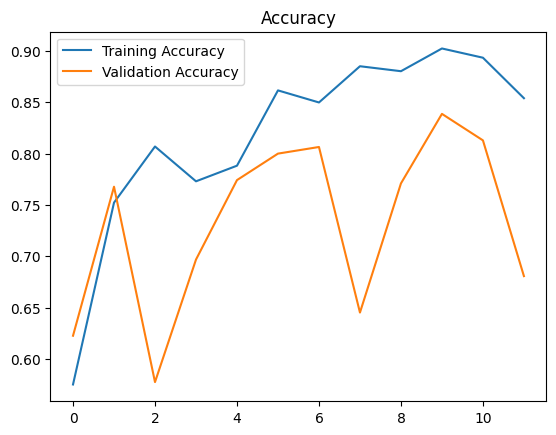

In [26]:
plot_metrics(history) 

In [27]:
best_model = load_model(filepath='models/cnn-parameters-improvement-10-0.84.model')
best_model.metrics_names

['loss', 'accuracy']

In [28]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

10/10 [==============================] - 7s 420ms/step - loss: 0.3448 - accuracy: 0.8516


In [29]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.34480541944503784
Test Accuracy = 0.85161292552948


In [16]:
vgg16=tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(240,240,3),pooling=max)


In [17]:
from tensorflow.keras.layers import Dropout


In [18]:
from tensorflow.keras.layers import Dropout
VGG16=tf.keras.Sequential()
VGG16.add(vgg16)
VGG16.add(Dropout(0.3))
VGG16.add(Flatten())
VGG16.add(Dropout(0.5))
VGG16.add(Dense(1, activation='sigmoid'))
VGG16.layers[0].trainable = False
VGG16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
VGG16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout_1 (Dropout)         (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 14739777 (56.23 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [20]:
filepath2="VGG-{epoch:02d}-{val_accuracy:.2f}"
checkpoint2 = ModelCheckpoint("models/{}.model".format(filepath2, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

In [21]:
VGG16.fit(x=X_train, y=y_train, batch_size=32, epochs=4, validation_data=(X_val, y_val), callbacks=[checkpoint2])


Epoch 1/4
46/46 [==============================] - ETA: 0s - loss: 0.5805 - accuracy: 0.6872INFO:tensorflow:Assets written to: models\VGG-01-0.75.model\assets


INFO:tensorflow:Assets written to: models\VGG-01-0.75.model\assets


46/46 [==============================] - 437s 9s/step - loss: 0.5805 - accuracy: 0.6872 - val_loss: 0.4584 - val_accuracy: 0.7548
Epoch 2/4
46/46 [==============================] - ETA: 0s - loss: 0.3021 - accuracy: 0.8789INFO:tensorflow:Assets written to: models\VGG-02-0.92.model\assets


INFO:tensorflow:Assets written to: models\VGG-02-0.92.model\assets


46/46 [==============================] - 389s 9s/step - loss: 0.3021 - accuracy: 0.8789 - val_loss: 0.2519 - val_accuracy: 0.9161
Epoch 3/4
46/46 [==============================] - ETA: 0s - loss: 0.2261 - accuracy: 0.9107INFO:tensorflow:Assets written to: models\VGG-03-0.94.model\assets


INFO:tensorflow:Assets written to: models\VGG-03-0.94.model\assets


46/46 [==============================] - 396s 9s/step - loss: 0.2261 - accuracy: 0.9107 - val_loss: 0.2149 - val_accuracy: 0.9355
Epoch 4/4
46/46 [==============================] - ETA: 0s - loss: 0.1784 - accuracy: 0.9419INFO:tensorflow:Assets written to: models\VGG-04-0.93.model\assets


INFO:tensorflow:Assets written to: models\VGG-04-0.93.model\assets


46/46 [==============================] - 419s 9s/step - loss: 0.1784 - accuracy: 0.9419 - val_loss: 0.1963 - val_accuracy: 0.9258


In [24]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

In [26]:
history1 = VGG16.history.history
for key in history1.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


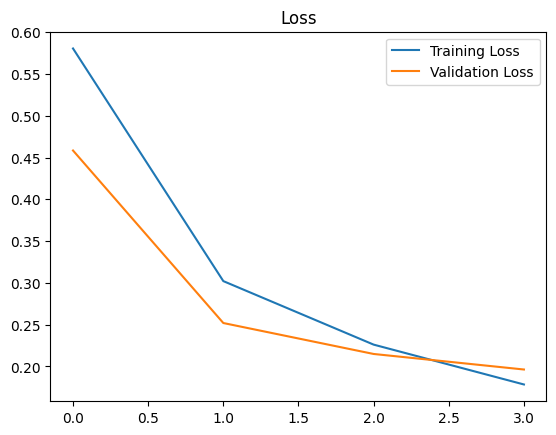

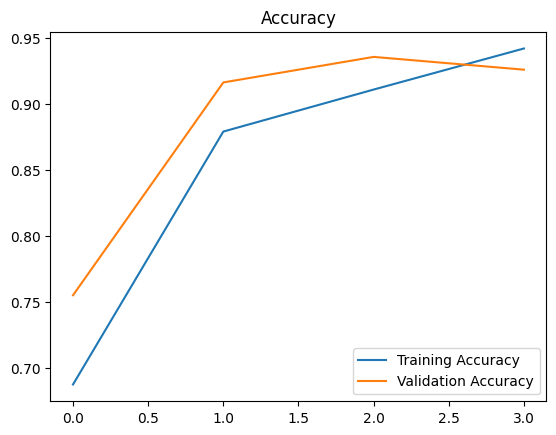

In [27]:
plot_metrics(history1) 

In [28]:
best_model1 = load_model(filepath='models/VGG-03-0.94.model')
best_model1.metrics_names

['loss', 'accuracy']

In [29]:
loss, acc = best_model1.evaluate(x=X_test, y=y_test)

10/10 [==============================] - 69s 7s/step - loss: 0.1971 - accuracy: 0.9548


In [30]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.19707171618938446
Test Accuracy = 0.9548386931419373
